https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import optuna
from reprpo.hp.helpers import optuna_df
from reprpo.training import train
from reprpo.experiments import experiment_configs
from reprpo.hp.space import search_spaces
from optuna.study.study import storages, get_all_study_names
from reprpo.hp.helpers import get_params, get_optuna_df


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = 4,2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from reprpo.hp.target import override, default_tuner_kwargs
from reprpo.experiments import experiment_configs
import copy

## Objective

In [6]:
SEED=42
key_metric = "acc_gain_vs_ref/oos"

In [ ]:
f_db = f"sqlite:///optuna.db"
f_db = f"sqlite:///../outputs/optuna4.db"
f = f_db.replace('sqlite:///', './')
print(f)
Path(f).parent.mkdir(parents=True, exist_ok=True)
f_db

./../outputs/optuna4.db


'sqlite:///../outputs/optuna4.db'

## Opt

Note on pruning. It's only really usefull with validation metrics and for long jobs over many epochs. I've got a small proxy job so there is no need.

In [8]:
def plot_param_importances(study, key_metric):
    df_res = get_optuna_df(study, key_metric)
    df2 = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)

    # plot_param_importances(study)
    # plt.show()

    for i in range(len(df_res)):
        row = df_res.iloc[i]
        param = row.name
        best = row.best
        x = f"params_{param}"
        hue = df2[x].apply(lambda x: x == best)
        if row.dist=='categorical':
            p = sns.catplot(data=df2, x=x, y="value", kind="boxen", 
                        #height=3, 
                        height=2, aspect=3,
                        legend=False,
                        hue=hue)
        else:
            plt.figure(figsize=(6, 2))
            sns.scatterplot(data=df2, x=x, y='value', hue=hue, alpha=0.5, ax=plt.gca())
            sns.scatterplot(data=df2[hue], x=x, y='value', ax=plt.gca(), marker='x', color='red', s=100)
            # TODO if it's a log dist make log
        plt.legend('off').remove()
        if isinstance(best, float):
            best = f"{best:.3g}"
        plt.title(f"{param} i={row.importance:2.2g} best={best}")
        plt.xlabel(None)
        # plt.ylabel(key_metric)
        plt.show()

In [9]:

study_names = get_all_study_names(storage=f_db)
res = {}
for study_name in study_names:
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        v = study.best_trial.values[0]
        df_res2 = optuna_df(study, key_metric)

        df = study.trials_dataframe().sort_values('value', ascending=False)
        n_c = len(df.query('state == "COMPLETE"'))
        n = len(df)
        dd = df['value'].dropna()
        nn = len(dd)//10
        top10 = dd.head(nn).mean()
        res[study_name] = dict(
            n_trials=n, best=v, n_trials_completed=n_c,
            top10_mean=top10,
            )
        # round just the numeric rows
        # print(df_res2.to_markdown())
        df_res2 = df_res2.applymap(lambda x: float(f"{x:2.3g}") if isinstance(x, (float,)) else x)
        print(df_res2.to_markdown())
        print()
    except ValueError as e:
        pass

df_res = pd.DataFrame(res).T.sort_values('best', ascending=False)
print(df_res.to_markdown())

| hs-ether-mse N=✓29/164, best=1.000   |   importance |     best |
|:-------------------------------------|-------------:|---------:|
| α                                    |        0.877 | 6.16     |
| lr                                   |        0.123 | 0.000457 |

| hs-ether-rank N=✓39/160, best=1.063   |   importance |     best |
|:--------------------------------------|-------------:|---------:|
| lr                                    |        0.983 | 0.000429 |
| β                                     |        0.017 | 9.17     |
| α                                     |        0     | 0.00241  |

| projgrad2 N=✓50/236, best=1.253   |   importance |     best |
|:----------------------------------|-------------:|---------:|
| mag_clip                          |        0.609 | 1        |
| lr                                |        0.271 | 0.000268 |
| reverse_pref                      |        0.062 | 1        |
| β                                 |        0.029 | 1.51     |
| weig

## plots

In [10]:
from optuna.visualization.matplotlib import plot_optimization_history
# plot_optimization_history(study)

hs-ether-mse


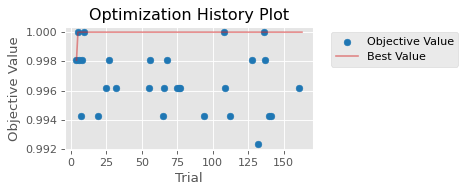

,importance,best
"hs-ether-mse N=✓29/164, best=1.000",,
α,0.897,6.155564
lr,0.103,0.000457


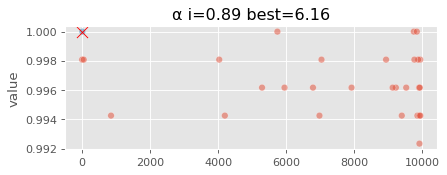

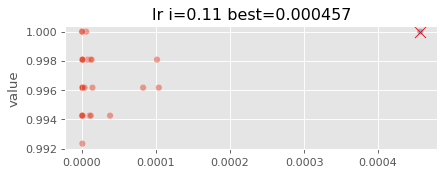

hs-ether-rank


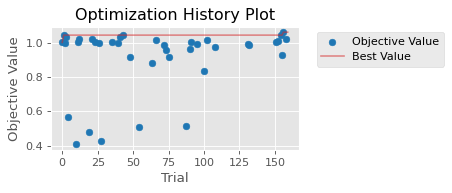

,importance,best
"hs-ether-rank N=✓39/160, best=1.063",,
lr,0.997,0.000429
β,0.003,9.170674
α,0.000,0.002411


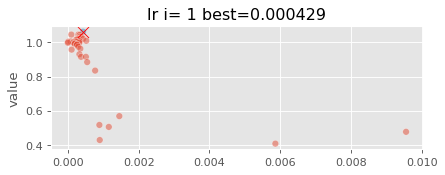

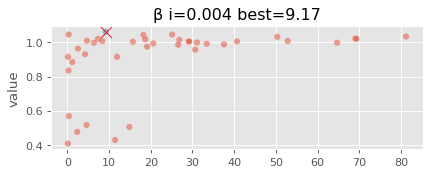

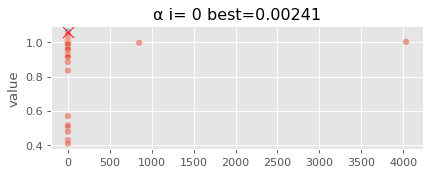

projgrad2


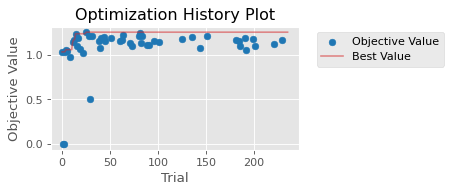

,importance,best
"projgrad2 N=✓50/236, best=1.253",,
mag_clip,0.675,1
lr,0.202,0.000268
neg_slope,0.038,0
weight_dim,0.036,1
reverse_pref,0.029,True
β,0.019,1.512788
scale_orth,0.000,False


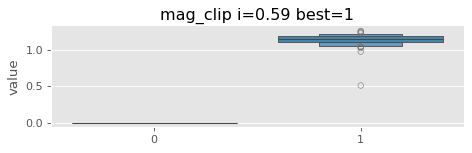

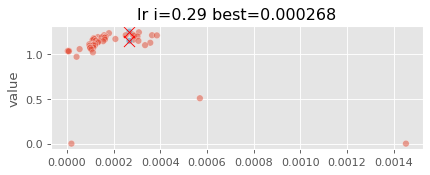

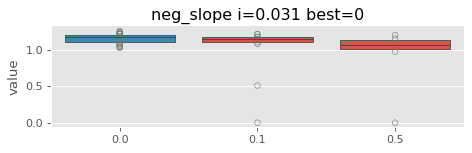

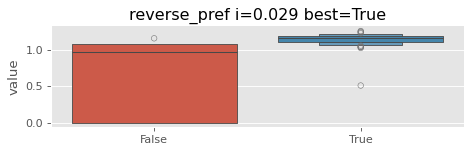

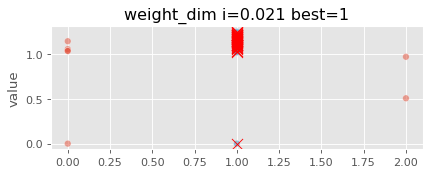

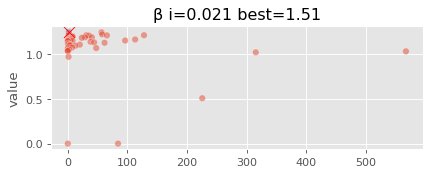

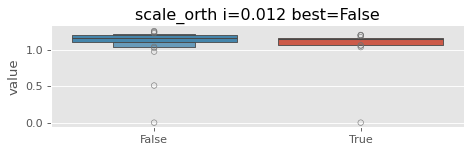

hs-ether-prefvec


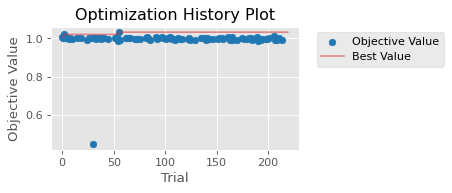

,importance,best
"hs-ether-prefvec N=✓97/220, best=1.033",,
lr,0.745,0.000051
β,0.173,0.95662
use_proj_rel,0.036,True
use_dpo_loss,0.032,False
use_orth_loss,0.013,True
use_angle_loss,0.002,True
use_nll_loss,0.000,False


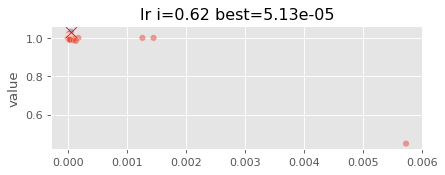

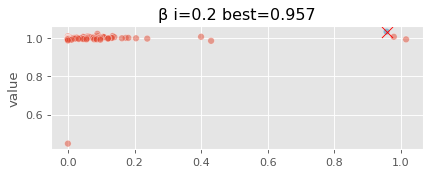

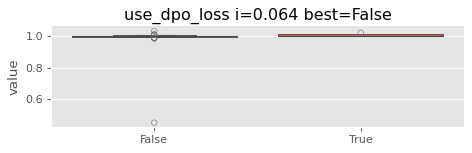

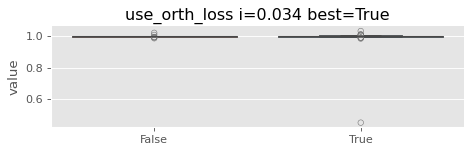

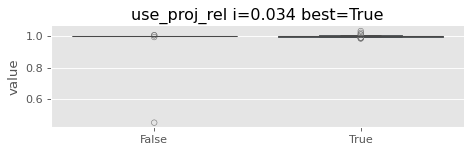

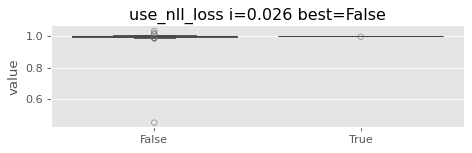

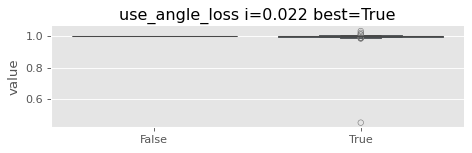

In [11]:

study_names = get_all_study_names(storage=f_db)

for study_name in study_names:
    print(study_name)
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        plot_optimization_history(study)
        plt.show()
        df_res2 = optuna_df(study, key_metric)
        display(df_res2)
        plot_param_importances(study, key_metric)
        # print()
    except ValueError as e:
        print('-')
    print('='*80)